In [1]:
import numpy as np
import pandas as pd
import os
from scipy.interpolate import CubicSpline as cs
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import copy
from scipy.interpolate import Akima1DInterpolator
from sklearn.preprocessing import StandardScaler
from scipy.signal import find_peaks
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter

In [2]:
def whitaker_hayes(intensity_data, kernel_size=3, threshold=8):
    return np.apply_along_axis(_whitaker_hayes_spectrum, axis=1, arr=intensity_data,
                               kernel_size=kernel_size, threshold=threshold)

def _whitaker_hayes_spectrum(spectrum_array, kernel_size, threshold):
    spectrum_array = copy.deepcopy(spectrum_array)
    spikes = _whitaker_hayes_modified_z_score(spectrum_array) > threshold

    while np.any(spikes):
        changes = False
        for i in range(len(spikes)):
            if spikes[i]:
                neighbours = np.arange(max(0, i - kernel_size), min(len(spectrum_array), i + 1 + kernel_size))
                valid_neighbors = spectrum_array[neighbours][~spikes[neighbours]]

                if valid_neighbors.size > 0:
                    spectrum_array[i] = np.mean(valid_neighbors)
                    spikes[i] = 0
                    changes = True
        if not changes:
            break

    return spectrum_array

def _whitaker_hayes_modified_z_score(intensity_values_array):
    median = np.median(intensity_values_array)
    mad = np.median(np.abs(intensity_values_array - median))
    modified_z_scores = 0.6745 * (intensity_values_array - median) / (mad if mad else 1)
    return modified_z_scores


def procesar_espectros(input_file, range=(500, 3700), points=3200,
                                     remover_rayos=True, kernel_size=3, threshold=8):
    """
    Procesa un archivo espectral eliminando rayos cósmicos, interpolando y normalizando.
    Devuelve un DataFrame listo para PCA.

    Parámetros:
    - nombre_archivo: str, ruta al archivo CSV
    - rango: tupla con (inicio, fin) para interpolación
    - puntos: número de puntos interpolados
    - remover_rayos: bool, si se aplicará el filtro Whitaker-Hayes
    """
    # Cargar archivo
    data = pd.read_csv(input_file, sep='\t')
    archive = pd.DataFrame(data)

    yi = archive.iloc[:, 1:].T.values  # espectros como filas
    xi = archive.iloc[:, 0].values     # eje espectral

    # Eliminar rayos cósmicos si se desea
    if remover_rayos:
        yi = whitaker_hayes(yi, kernel_size=kernel_size, threshold=threshold)

    # Interpolación cúbica
    xf = np.linspace(range[0], range[1], points)
    espectra_interpolates = np.array([cs(xi, yi_row)(xf) for yi_row in yi])

    # Normalización min-max por espectro
    def normalize_minmax(arr):
        if np.max(arr) != np.min(arr):
            return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
        else:
            return np.zeros_like(arr)

    espectra_normalized = np.array([normalize_minmax(row) for row in espectra_interpolates])

    df_final = pd.DataFrame(espectra_normalized, columns=xf)
    return df_final

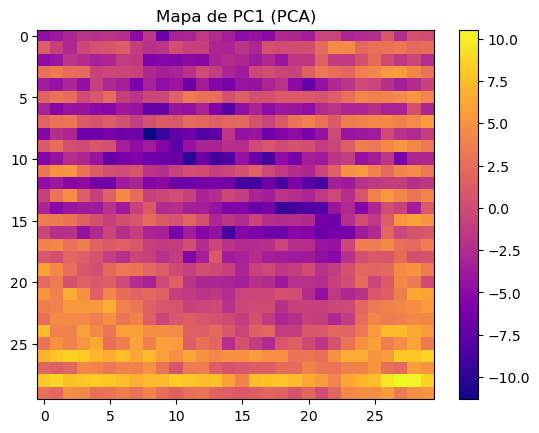

In [51]:
# PCA
scaler = StandardScaler() # Estandarización de varianza
n_components = 900
pca = PCA(n_components=n_components)

# Transponer para que cada columna sea un espectro
spectra_std = scaler.fit_transform(datos.T)
pc_scores = pca.fit_transform(spectra_std.T)
pcscores = pd.DataFrame(pc_scores)

# Mapa 30x30 usando la primera componente principal
final = np.array(pcscores.iloc[:, 0]).reshape(30, 30)


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.interpolate import CubicSpline as cs
import copy

In [4]:
def whitaker_hayes(intensity_data, kernel_size=3, threshold=8):
    return np.apply_along_axis(_whitaker_hayes_spectrum, axis=1, arr=intensity_data,
                               kernel_size=kernel_size, threshold=threshold)

def _whitaker_hayes_spectrum(spectrum_array, kernel_size, threshold):
    spectrum_array = copy.deepcopy(spectrum_array)
    spikes = _whitaker_hayes_modified_z_score(spectrum_array) > threshold

    while np.any(spikes):
        changes = False
        for i in range(len(spikes)):
            if spikes[i]:
                neighbours = np.arange(max(0, i - kernel_size), min(len(spectrum_array), i + 1 + kernel_size))
                valid_neighbors = spectrum_array[neighbours][~spikes[neighbours]]

                if valid_neighbors.size > 0:
                    spectrum_array[i] = np.mean(valid_neighbors)
                    spikes[i] = 0
                    changes = True
        if not changes:
            break

    return spectrum_array

def _whitaker_hayes_modified_z_score(intensity_values_array):
    median = np.median(intensity_values_array)
    mad = np.median(np.abs(intensity_values_array - median))
    modified_z_scores = 0.6745 * (intensity_values_array - median) / (mad if mad else 1)
    return modified_z_scores

def procesar_espectros(input_file, range=(500, 3700), points=3200,
                       remover_rayos=True, kernel_size=3, threshold=8):
    """
    Procesa un archivo espectral eliminando rayos cósmicos, interpolando y normalizando.
    Devuelve un DataFrame listo para PCA.
    """
    # Leer archivo (detecta separador automáticamente)
    data = pd.read_csv(input_file, sep=None, engine='python')
    archive = pd.DataFrame(data)

    yi = archive.iloc[:, 1:].T.values  # espectros como filas
    xi = archive.iloc[:, 0].values     # eje espectral

    # Filtro de rayos cósmicos
    if remover_rayos:
        yi = whitaker_hayes(yi, kernel_size=kernel_size, threshold=threshold)

    # Interpolación cúbica
    xf = np.linspace(range[0], range[1], points)
    espectra_interpolates = np.array([cs(xi, yi_row)(xf) for yi_row in yi])

    # Normalización min–max
    def normalize_minmax(arr):
        if np.max(arr) != np.min(arr):
            return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
        else:
            return np.zeros_like(arr)

    espectra_normalized = np.array([normalize_minmax(row) for row in espectra_interpolates])

    df_final = pd.DataFrame(espectra_normalized, columns=xf)
    return df_final

In [5]:
folders = ["4T1", "MDA", "MCF10"]

X_total = []
y_total = []

# Procesar cada carpeta
for label in folders:
    for file in os.listdir(label):
        if file.endswith(".csv"):
            filepath = os.path.join(label, file)
            try:
                df = procesar_espectros(filepath)
                X_total.append(df.values)
                y_total.extend([label] * df.shape[0])
            except Exception as e:
                print(f"⚠️ Error procesando {filepath}: {e}")

In [6]:
# Combinar todos los espectros
X = np.vstack(X_total)
y = np.array(y_total)

print("✅ Datos procesados correctamente")
print("Dimensiones de X:", X.shape)
print("Clases:", np.unique(y))

MemoryError: Unable to allocate 11.2 GiB for an array with shape (468900, 3200) and data type float64

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA opcional
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Entrenamiento LDA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42, stratify=y)

lda = LDA(n_components=2)
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

acc = accuracy_score(y_test, y_pred)

In [ ]:
print(f"\n🔹 Exactitud del clasificador LDA: {acc*100:.2f}%")

In [ ]:
# ============================================================
# === MATRIZ DE CONFUSIÓN ====================================
# ============================================================
cm = confusion_matrix(y_test, y_pred, labels=folders)
ConfusionMatrixDisplay(cm, display_labels=folders).plot(cmap='Blues')
plt.title("Matriz de confusión - Clasificador LDA")
plt.show()


In [ ]:
# ============================================================
# === VISUALIZACIÓN LDA 2D ===================================
# ============================================================
X_lda = lda.transform(X_pca)
colors = {"4T1": "red", "MDA": "blue", "MCF10": "green"}

plt.figure(figsize=(8,6))
for label in np.unique(y):
    plt.scatter(X_lda[y == label, 0],
                X_lda[y == label, 1],
                label=label,
                alpha=0.7,
                color=colors[label])

plt.title("Proyección LDA de los espectros Raman (Whitaker–Hayes + PCA)")
plt.xlabel("LDA 1")
plt.ylabel("LDA 2")
plt.legend()
plt.grid(True)
plt.show()